In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.random.seed(69)

import tqdm

from sklearn.decomposition import PCA

from viz_helpers import plot_w_genre
import helpers as h

In [108]:
movie_df = pd.read_csv('data/movies_c.txt', delimiter='\t', header=None,
                       names=["Movie Id", "Movie Title", "Unknown", "Action", 
                              "Adventure", "Animation", "Childrens", "Comedy", 
                              "Crime", "Documentary", "Drama", "Fantasy", 
                              "Film-Noir", "Horror", "Musical", "Mystery", 
                              "Romance", "Sci-Fi", "Thriller", "War", 
                              "Western"])

data_df = pd.read_csv('data/data_c.txt', delimiter='\t', header=None,
                      names=["User Id", "Movie Id", "Rating"])
train_df = pd.read_csv('data/train_c.txt', delimiter='\t', header=None,
                      names=["User Id", "Movie Id", "Rating"])
test_df = pd.read_csv('data/test_c.txt', delimiter='\t', header=None,
                      names=["User Id", "Movie Id", "Rating"])

# 4) Basic Visualization

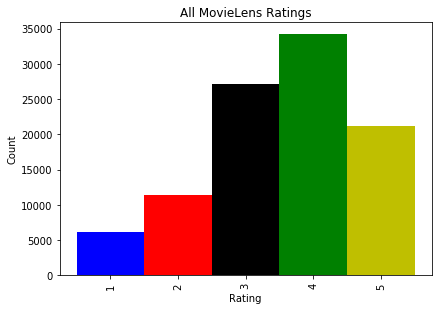

In [109]:
hist_vals = data_df["Rating"].value_counts().sort_index()
hist_vals.plot(kind="bar", width=1.0, color=['b', 'r', 'k', 'g', 'y'])
plt.tight_layout(); plt.xlabel("Rating"); plt.ylabel("Count");
plt.title('All MovieLens Ratings');

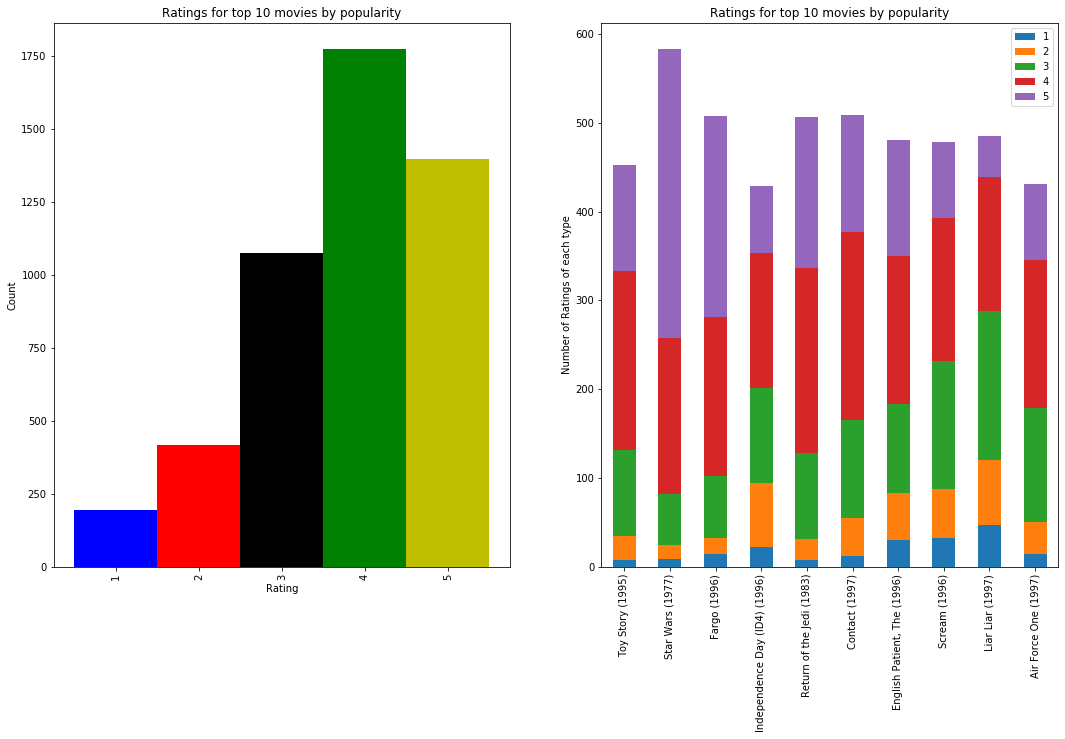

In [110]:
nMovies = 10
pop_movs = data_df["Movie Id"].value_counts()[:nMovies].index
pop_df = data_df.loc[data_df["Movie Id"].isin(pop_movs), :]

# histogram the ratings
ax = plt.subplot(121)
hist_vals = pop_df["Rating"].value_counts().sort_index()
hist_vals.plot(kind="bar", width=1.0, ax=ax, color=['b', 'r', 'k', 'g', 'y'])
ax.set_xlabel("Rating"); ax.set_ylabel("Count");
ax.set_title(f'Ratings for top {nMovies} movies by popularity');

ax = plt.subplot(122)
titles, vals = [], []
for Id, sub_df in pop_df.groupby("Movie Id"):
    titles.append(movie_df.loc[movie_df["Movie Id"] == Id, "Movie Title"].values[0])
    vals.append(sub_df["Rating"].value_counts().sort_index().values)
df = pd.DataFrame(index = titles, data = np.array(vals), columns = np.arange(1, 6))
df.plot(kind='bar', stacked=True, ax = ax)
ax.set_ylabel("Number of Ratings of each type");
ax.set_title(f'Ratings for top {nMovies} movies by popularity');


plt.gcf().set_size_inches(18, 10)

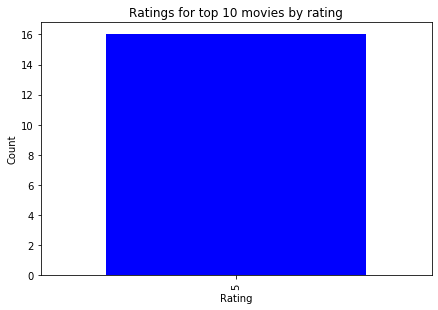

In [111]:
nMovies = 10
av_ratings = data_df.groupby("Movie Id").aggregate('mean')
sort_ratings = av_ratings.sort_values(by='Rating', axis='index', ascending=False)
best_movs = sort_ratings[:nMovies].index
best_df = data_df.loc[data_df["Movie Id"].isin(best_movs), :]

# histogram the ratings
hist_vals = best_df["Rating"].value_counts().sort_index()
hist_vals.plot(kind="bar", width=1.0, color=['b', 'r', 'k', 'g', 'y'])
plt.tight_layout(); plt.xlabel("Rating"); plt.ylabel("Count");
plt.title(f'Ratings for top {nMovies} movies by rating');

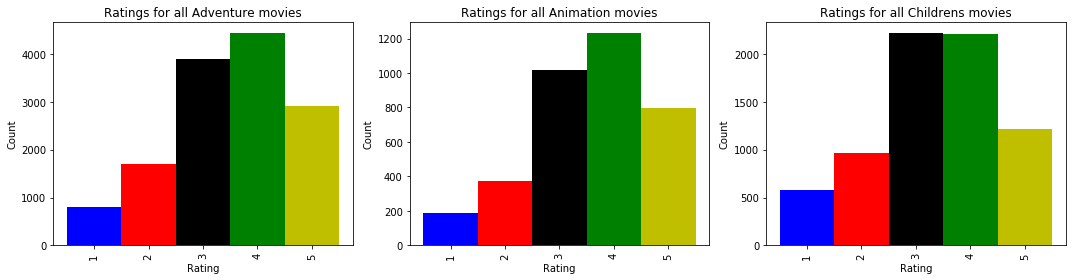

In [112]:
genres = ["Adventure", "Animation", "Childrens"]
fig, axes = plt.subplots(1, len(genres), figsize = (5 * len(genres), 4))

for ax, genre in zip(axes, genres):
    ids = movie_df.loc[movie_df[genre] == 1, "Movie Id"]
    ratings = data_df.loc[data_df["Movie Id"].isin(ids), "Rating"]
    hist_vals = ratings.value_counts().sort_index()
    hist_vals.plot(kind="bar", width=1.0, color=['b', 'r', 'k', 'g', 'y'], ax=ax)
    ax.set_xlabel("Rating"); ax.set_ylabel("Count");
    ax.set_title(f'Ratings for all {genre} movies');
    
plt.tight_layout();

# 5)

In [113]:
def grad_A(Ai, Bj, Ui, Vj, Yij, mu, reg, eta):
    return eta * (reg * Ai - (Yij - mu - np.dot(Ui, Vj) - Ai - Bj))

def grad_B(Ai, Bj, Ui, Vj, Yij, mu, reg, eta):
    return eta * (reg * Bj - (Yij - mu - np.dot(Ui, Vj) - Ai - Bj))

def grad_U(Ai, Bj, Ui, Vj, Yij, mu, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - mu - np.dot(Ui, Vj) - Ai - Bj)) 

def grad_V(Ai, Bj, Ui, Vj, Yij, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - mu - np.dot(Ui, Vj) - Ai - Bj)) 

def get_err(U, V, A, B, Y, mu, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
#     Y2 = Y - np.array([[1, 1, 0]]) # Fix one-indexing
#     reg_err = reg / 2 * (np.linalg.norm(U) ** 2 + np.linalg.norm(V) ** 2)
#     Is, Js, Y_ij = Y2[:, 0], Y2[:, 1], Y2[:, 2]
#     mse = np.sum((Y_ij - np.sum(U[Is] * V[Js], axis=1)) ** 2) / 2
#     return (reg_err + mse) / Y.shape[0]
    predict = np.matmul(U, np.transpose(V))
    err = 0
    for row in Y:
        i = row[0] - 1
        j = row[1] - 1
        err += (row[2] - mu - (predict[i][j] + A[i] + B[j]))**2
        
    return (reg/2 * ((np.linalg.norm(U))**2 + (np.linalg.norm(V))**2 + (np.linalg.norm(A))**2 + (np.linalg.norm(B))**2) 
            + 0.5 * err)/len(Y)

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300,
               desc='train_loop'):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    
    U = np.random.rand(M, K) - 0.5
    V = np.random.rand(N, K) - 0.5
    A = np.random.rand(M, 1) - 0.5
    B = np.random.rand(N, 1) - 0.5
    mu = np.mean(Y[:,2])
    old_loss = get_err(U, V, A, B, Y, mu, reg=reg)
    
    for e in (range(max_epochs)):
        Y_curr = Y[np.random.permutation(Y.shape[0])]
        for (i, j, y_ij) in Y_curr:
            i, j = i-1, j-1 # Fix One-indexing
            gU = grad_U(A[i], B[j], U[i], V[j], y_ij, mu, reg, eta)
            gV = grad_V(A[i], B[j], U[i], V[j], y_ij, mu, reg, eta)
            gA = grad_A(A[i], B[j], U[i], V[j], y_ij, mu, reg, eta)
            gB = grad_B(A[i], B[j], U[i], V[j], y_ij, mu, reg, eta)
            U[i] -= gU
            V[j] -= gV
            A[i] -= gA
            B[j] -= gB
             
        new_loss = get_err(U, V, A, B, Y, mu, reg=reg)
        if e == 0:
            loss_delta = old_loss - new_loss
        if (old_loss - new_loss) / loss_delta <= eps:
            break
        old_loss = new_loss
        
    return (U, V, get_err(U, V, A, B, Y, mu, reg=0.0))

In [114]:
Y = train_df.values
M = train_df["User Id"].max()
N = movie_df["Movie Id"].max()

K = 20; eta = 0.03; reg=0.1

U, V, err = train_model(M, N, K, eta, reg, Y)
print(err)

[0.26182614]


In [115]:
from sklearn.decomposition import PCA

In [116]:
pca = PCA(2)

In [117]:
V_p = pca.fit_transform(V)
U_p = pca.transform(U)

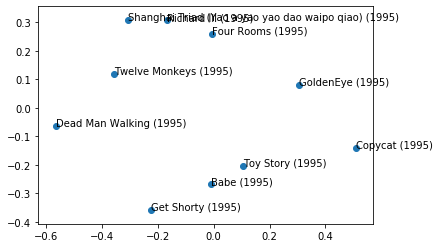

In [118]:
n_mov = 10
ax = plt.subplot(111)
ax.scatter(V_p[:n_mov, 0], V_p[:n_mov, 1])

for i, txt in enumerate(movie_df["Movie Title"][:n_mov]):
    ax.annotate(txt, (V_p[i, 0], V_p[i, 1]))

In [119]:
genres = ["Adventure", "Animation"]
n_mov = 10

ids1 = movie_df.loc[movie_df[genres[0]], "Movie Id"][:n_mov]

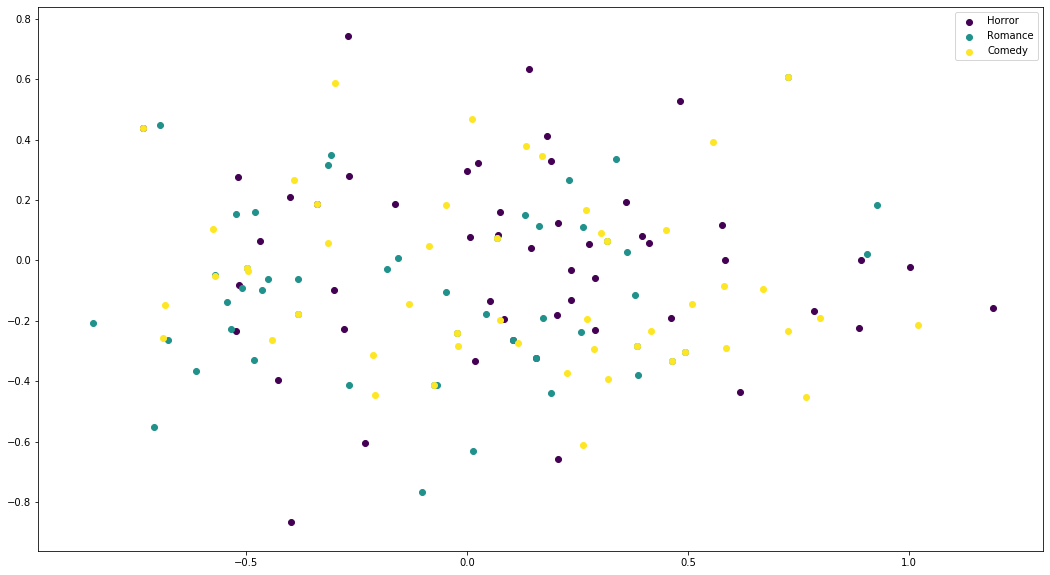

In [120]:
pca = PCA(3)
V_p = pca.fit_transform(V)
U_p = pca.transform(U)

genres = ["Horror", "Romance", "Comedy"]
n_mov = 50
plot_w_genre(genres, movie_df, V_p, n_mov=n_mov, dim_3=False, annotate = False)
plt.gcf().set_size_inches(18, 10)

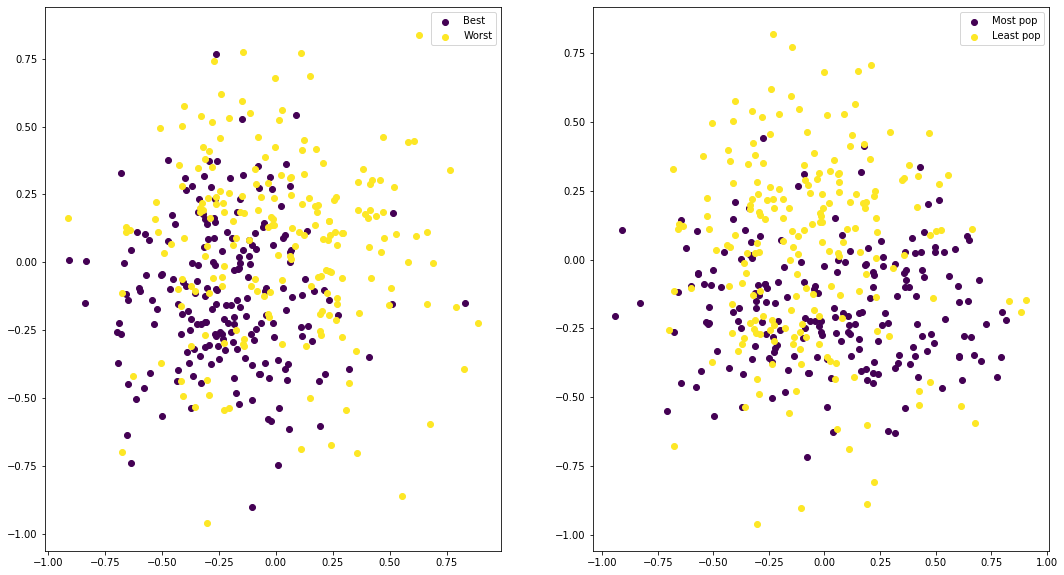

In [121]:
n_mov = 200
fig, ax = plt.subplots(1,2, figsize=(18, 10))
ids1 = [h.best_movs_ids(data_df, n_mov, get_worst=False),\
       h.best_movs_ids(data_df, n_mov, get_worst=True)]
ids2 = [h.pop_movs_ids(data_df, n_mov, get_least_pop=False),\
       h.pop_movs_ids(data_df, n_mov, get_least_pop=True)]
h.plot_w_ids(ids1, movie_df, V_p, labels=["Best", "Worst"], annotate=False, ax=ax[0])
h.plot_w_ids(ids2, movie_df, V_p, labels=["Most pop", "Least pop"], annotate=False, ax=ax[1])